In [ ]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import json
from hyperparameter_tuning import get_param_grids, run_all_models_comparison

# Constants
RANDOM_STATE = 42
CV_SPLITS = 10

# Cell 2: Load and Prepare Data
print("Loading and preparing data...")
data = pd.read_csv('augmented_bakery_data.csv')

# Encode labels
le_product = LabelEncoder()
le_storage = LabelEncoder()
data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])
data['Storage_Condition_encoded'] = le_storage.fit_transform(data['Storage_Condition'])

# Prepare features
spectral_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
X_spectral = data[spectral_cols]
product_type = data['Product_Type_encoded'].values.reshape(-1, 1)

# Scale spectral features
scaler = StandardScaler()
X_spectral_scaled = scaler.fit_transform(X_spectral)

# Prepare datasets
X_with_product = np.column_stack([X_spectral_scaled, product_type])
X_without_product = X_spectral_scaled

# Target variable
y_storage = data['Storage_Condition_encoded'].values

print(f"Dataset shapes:")
print(f"X without product type: {X_without_product.shape}")
print(f"X with product type: {X_with_product.shape}")
print(f"Number of storage conditions: {len(np.unique(y_storage))}")
print(f"Storage conditions: {dict(zip(le_storage.classes_, le_storage.transform(le_storage.classes_)))}")

# Cell 3: Run Tuning
print("\nRunning hyperparameter tuning...")
all_results = run_all_models_comparison(X_with_product, X_without_product, y_storage)

# Cell 4: Save Results and Display Summary
results_summary = {
    'with_product_type': {},
    'without_product_type': {}
}

print("\nModel Performance Summary:")
print("=" * 80)
print("\nWith Product Type Features:")
print("-" * 40)
for model_name, results in all_results.items():
    score = results['with_product_type']['best_score']
    params = results['with_product_type']['best_params']
    results_summary['with_product_type'][model_name] = {
        'best_params': params,
        'best_score': score
    }
    print(f"\n{model_name}:")
    print(f"Best Score: {score:.4f}")
    print(f"Best Parameters: {params}")

print("\nWithout Product Type Features:")
print("-" * 40)
for model_name, results in all_results.items():
    score = results['without_product_type']['best_score']
    params = results['without_product_type']['best_params']
    results_summary['without_product_type'][model_name] = {
        'best_params': params,
        'best_score': score
    }
    print(f"\n{model_name}:")
    print(f"Best Score: {score:.4f}")
    print(f"Best Parameters: {params}")

# Save the results
with open('storage_condition_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("\nResults have been saved to 'storage_condition_results.json'")

Product type tunning


In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import json
from hyperparameter_tuning import get_param_grids, run_all_models_comparison

# Constants
RANDOM_STATE = 42
CV_SPLITS = 10

# Cell 2: Load and Prepare Data
print("Loading and preparing data...")
data = pd.read_csv('augmented_bakery_data.csv')

# Encode labels
le_product = LabelEncoder()
le_storage = LabelEncoder()
data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])
data['Storage_Condition_encoded'] = le_storage.fit_transform(data['Storage_Condition'])

# Separate spectral features and storage condition
spectral_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
X_spectral = data[spectral_cols]
storage_condition = data['Storage_Condition_encoded'].values.reshape(-1, 1)

# Scale spectral features
scaler = StandardScaler()
X_spectral_scaled = scaler.fit_transform(X_spectral)

# Prepare two versions of the dataset
X_without_storage = X_spectral_scaled
X_with_storage = np.column_stack([X_spectral_scaled, storage_condition])  # Storage condition remains unscaled

# Target variable (now product type)
y_product = data['Product_Type_encoded'].values

print(f"Dataset shapes:")
print(f"X without storage condition: {X_without_storage.shape}")
print(f"X with storage condition: {X_with_storage.shape}")
print(f"Number of product types: {len(np.unique(y_product))}")
print(f"Product types: {dict(zip(le_product.classes_, le_product.transform(le_product.classes_)))}")

# Cell 3: Run Tuning
print("\nRunning hyperparameter tuning for product type classification...")
all_results = run_all_models_comparison(X_with_storage, X_without_storage, y_product)

# Cell 4: Save Results
Product_type_parameters_summary = {
    'with_storage_condition': {},
    'without_storage_condition': {}
}

# Extract best parameters and scores for each model
for model_name, results in all_results.items():
    Product_type_parameters_summary['with_storage_condition'][model_name] = results['with_product_type']['best_params'],  # Note: keys remain the same from the function
    Product_type_parameters_summary['without_storage_condition'][model_name] =results['without_product_type']['best_params'],

# Save the results
with open('product_type_tuning_results.json', 'w') as f:
    json.dump(Product_type_parameters_summary, f, indent=4)


Loading and preparing data...
Dataset shapes:
X without storage condition: (180, 202)
X with storage condition: (180, 203)
Number of product types: 2
Product types: {'Bread': 0, 'Cookies': 1}

Running hyperparameter tuning for product type classification...

######################################################################
Running comparison for SVM
######################################################################

Tuning SVM with product type features...
Fitting 10 folds for each of 32 candidates, totalling 320 fits

Tuning SVM without product type features...
Fitting 10 folds for each of 32 candidates, totalling 320 fits

Comparison Results for SVM

Results with product type:
Best score: 0.9944
Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Results without product type:
Best score: 0.9833
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Performance difference (with - without): 0.0111

Recommendation: Consider using the model without product t

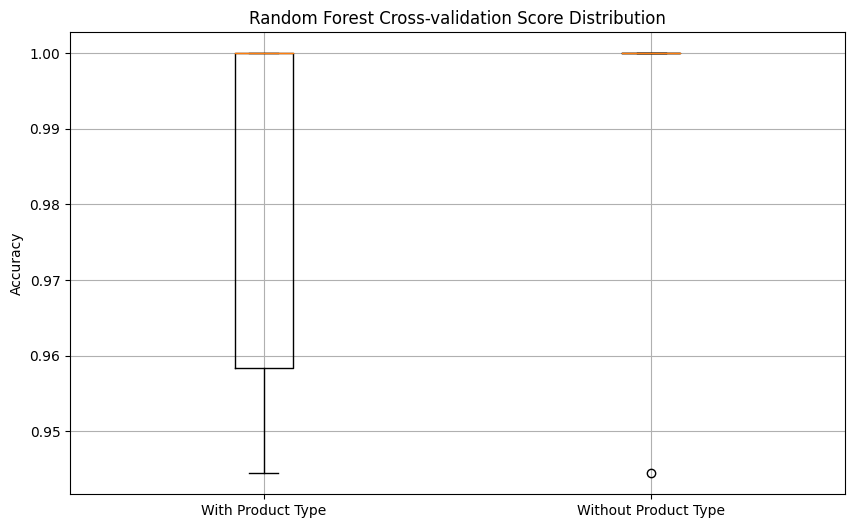


Cross-validation scores summary for Random Forest:

With Product Type:
Mean: 0.9833
Std: 0.0255

Without Product Type:
Mean: 0.9944
Std: 0.0167


In [11]:

# Add this new cell
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def plot_cv_score_distribution(X_with, X_without, y, model_name):
    """Plot distribution of cross-validation scores"""
    # Get the best models
    model_with = all_results[model_name]['with_product_type']['best_model']
    model_without = all_results[model_name]['without_product_type']['best_model']
    
    # Get cross-validation scores
    scores_with = cross_val_score(model_with, X_with, y, cv=10)
    scores_without = cross_val_score(model_without, X_without, y, cv=10)
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    plt.boxplot([scores_with, scores_without], labels=['With Product Type', 'Without Product Type'])
    plt.title(f'{model_name} Cross-validation Score Distribution')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    # Print statistical summary
    print(f"\nCross-validation scores summary for {model_name}:")
    print("\nWith Product Type:")
    print(f"Mean: {scores_with.mean():.4f}")
    print(f"Std: {scores_with.std():.4f}")
    print("\nWithout Product Type:")
    print(f"Mean: {scores_without.mean():.4f}")
    print(f"Std: {scores_without.std():.4f}")

# Plot CV score distribution for Random Forest
plot_cv_score_distribution(X_with_product, X_without_product, y_storage, 'Random Forest')